In [1]:
import tensorflow
import numpy as np
import pandas as pd
import os
import tensorflow.keras as keras
zip_file=keras.utils.get_file(
    fname="gamma_angle_position_5deg_xy.h5",
    origin="https://zenodo.org/record/846388/files/gamma_angle_position_5deg_xy.h5?download=1",
    extract=True

)
dirnam=os.path.join(os.path.dirname(zip_file), "gamma_angle_position_5deg_xy.h5")
import h5py
import h5py
zip_file


2060006240/2060006240 [==============================] - 66s 0us/step


'/root/.keras/datasets/gamma_angle_position_5deg_xy.h5'

In [2]:
x=h5py.File(zip_file)
layer_0_data = (np.array(h5py.File(zip_file)["layer_0"][:]))
layer_1_data = (np.array(h5py.File(zip_file)["layer_1"][:]))
layer_2_data = (np.array(h5py.File(zip_file)["layer_2"][:]))
energy=(np.array(h5py.File(zip_file)["energy"]))
energy=energy.reshape(energy.shape[0])
print(layer_0_data.shape)

nrm_l0=np.max(layer_0_data)
nrm_l1=np.max(layer_1_data)
nrm_l2=np.max(layer_2_data)
nrm_e=np.max(energy)
rng = np.random.default_rng()
def noise_add(layer_name, alpha, noise):
    noise_ln = rng.normal(alpha, noise ,layer_name.shape[0]*layer_name.shape[1]*layer_name.shape[2])
    noise_ln = noise_ln.reshape(layer_name.shape[0],layer_name.shape[1],layer_name.shape[2])
    layer_name = layer_name + noise_ln
    layer_name[layer_name<0] = 0
noise_add(layer_0_data,0,167)
noise_add(layer_1_data,0,167)
noise_add(layer_2_data,0,167)

(500000, 3, 96)


In [4]:
Layer_0_data_preprocessed=layer_0_data/nrm_l0
Layer_1_data_preprocessed=layer_1_data/nrm_l1
Layer_2_data_preprocessed=layer_2_data/nrm_l2
energy = energy / nrm_e
flatten_layer_0=Layer_0_data_preprocessed.reshape(500000,3*96)
flatten_layer_1=Layer_1_data_preprocessed.reshape(500000,12*12)
flatten_layer_2=Layer_2_data_preprocessed.reshape(500000,6*12)

In [5]:
from sklearn.model_selection import train_test_split
layer_0_train, layer_0_test, energy_train, energy_test,  layer_1_train,layer_1_test, layer_2_train, layer_2_test,= train_test_split(flatten_layer_0,  energy, flatten_layer_1, flatten_layer_2,  test_size=0.4, random_state=42)
layer_0_train_2D, layer_0_test_2D, energy_train, energy_test,  layer_1_train_2D,layer_1_test_2D, layer_2_train_2D, layer_2_test2D,= train_test_split(Layer_0_data_preprocessed,  energy, Layer_1_data_preprocessed, Layer_2_data_preprocessed,  test_size=0.4, random_state=42)

In [6]:
lc1_test=np.array([np.concatenate((layer_0_test, layer_1_test, layer_2_test),axis=1)  ])
lc1_train=np.array([np.concatenate((layer_0_train, layer_1_train, layer_2_train),axis=1)  ])
lc1_train=lc1_train.reshape(lc1_train.shape[1],lc1_train.shape[2])
lc1_test=lc1_test.reshape(lc1_test.shape[1],lc1_test.shape[2])

In [48]:
#DNN Example
x_res,x_val,y_res,y_val=train_test_split(lc1_train, energy_train, test_size=0.2, random_state=42)
def dnn_opt_keras(x_train, y_train,x_val,y_val, params):
    
    inputs = layers.Input(shape=(144+(96*3)+72,), name="input_features")
    x = inputs
    hidden_units=[1024,512,64]
    for units in hidden_units:        
        x  = layers.Dense(units, activation=tf.nn.relu)(x)
        x  = layers.Dropout(params["Dropout"])(x)
    logits = layers.Dense(1, name="output")(x)
    model=keras.Model(inputs=inputs, outputs=logits, name="dnn")
    # Create the model.
    model.compile(
        optimizer=keras.optimizers.Adam(params["l_r"]),
        loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")#,
        #metrics=tf.keras.metrics.BinaryAccuracy(),
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, restore_best_weights=True
    )
    
    history = model.fit(
        x_train,
        y_train,
        epochs=50,
        batch_size=params["batch_size"],
        validation_data=[x_val, y_val],
        callbacks=[early_stopping],
    )

    validation_acc=np.amin(history.history["val_loss"])
    return history, model 

In [49]:
p={
     'batch_size': [512,1024,2028,4056],
     'Dropout': [0,0.2,0.4,0.6],
    "l_r":[0.001,0.002,0.003]
}
import talos
import keras.layers as layers
import tensorflow as tf

t = talos.Scan(x=x_res,
               y=y_res,
               model=dnn_opt_keras,
               params=p,
               experiment_name='dnn_optimization',
               round_limit=10,
               disable_progress_bar=True)

Epoch 1/50
83/83 [==============================] - 2s 23ms/step - loss: 0.0222 - val_loss: 0.0014
Epoch 2/50
83/83 [==============================] - 1s 18ms/step - loss: 0.0087 - val_loss: 9.7422e-04
Epoch 3/50
83/83 [==============================] - 1s 18ms/step - loss: 0.0076 - val_loss: 6.0132e-04
Epoch 4/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0071 - val_loss: 6.4350e-04
Epoch 5/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0067 - val_loss: 8.7308e-04
Epoch 6/50
83/83 [==============================] - 1s 18ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 7/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0064 - val_loss: 9.6376e-04
Epoch 8/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0065 - val_loss: 8.9029e-04
Epoch 9/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 10/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0062 - va

In [59]:
t.data

,start,end,duration,round_epochs,loss,val_loss,batch_size,Dropout,l_r
0,10/09/22-080616,10/09/22-080730,73.518936,50,0.003729,0.000394,2028,0.4,0.002
1,10/09/22-080731,10/09/22-080906,95.184793,50,0.001002,0.000156,1024,0.2,0.001
2,10/09/22-080907,10/09/22-081016,69.593868,50,0.000049,0.000061,2028,0.0,0.003
3,10/09/22-081017,10/09/22-081127,69.689066,50,0.000045,0.000071,2028,0.0,0.002
4,10/09/22-081127,10/09/22-081228,60.605678,50,0.006989,0.001498,4056,0.4,0.003
5,10/09/22-081229,10/09/22-081352,83.510130,50,0.002583,0.000318,4056,0.2,0.002
6,10/09/22-081353,10/09/22-081559,126.589433,50,0.002962,0.002006,512,0.4,0.003
7,10/09/22-081600,10/09/22-081714,74.415919,50,0.001237,0.000143,2028,0.2,0.002
8,10/09/22-081715,10/09/22-081815,60.119311,50,0.002588,0.000489,4056,0.2,0.001
9,10/09/22-081816,10/09/22-081950,94.538949,50,0.011234,0.002263,1024,0.6,0.002


In [58]:
t.learning_entropy
evaluate_object = talos.Evaluate(t)
evaluate_object.evaluate(lc1_test, energy_test, folds=10, metric='val_loss', task='continuous')

625/625 [==============================] - 1s 2ms/step


[0.026169874493641446,
 0.026347464153220444,
 0.026227083022896204,
 0.026537606372185035,
 0.026381869738146088,
 0.026274729368182773,
 0.026141554258789224,
 0.026236079579408964,
 0.026193019295545645,
 0.026175922914961826]

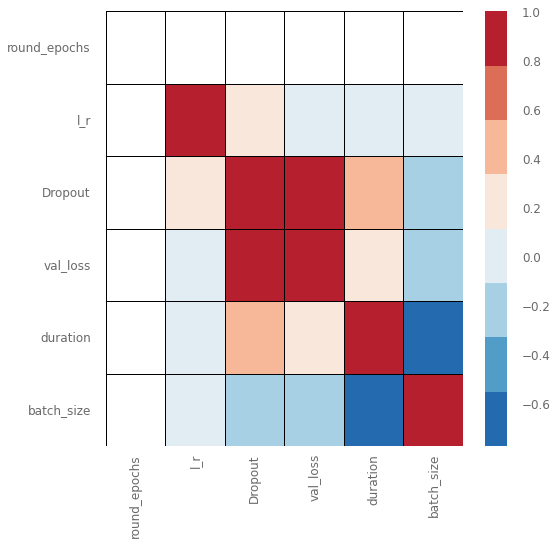

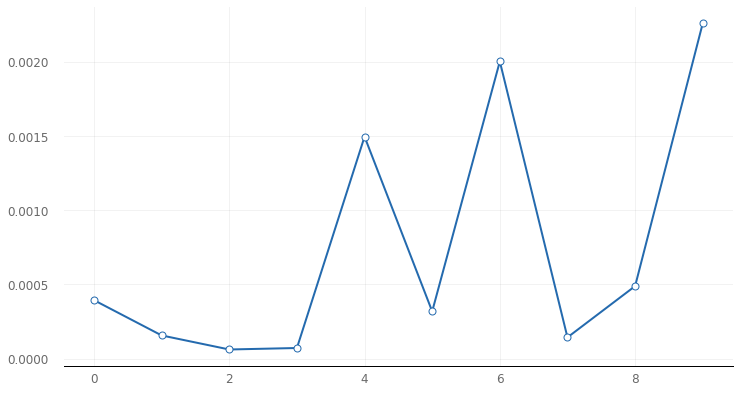

In [68]:
analyze_object = talos.Analyze(t)
x=analyze_object.best_params('val_loss', [ 'loss', 'val_loss'])
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])
analyze_object.plot_line('val_loss')


In [69]:
analyze_object.best_params('val_loss', [ 'loss', 'val_loss'])

array([[50, 0.002, 0.6, '10/09/22-081816', '10/09/22-081950',
        94.53894853591919, 1024, 0],
       [50, 0.003, 0.4, '10/09/22-081353', '10/09/22-081559',
        126.58943295478821, 512, 1],
       [50, 0.003, 0.4, '10/09/22-081127', '10/09/22-081228',
        60.60567808151245, 4056, 2],
       [50, 0.001, 0.2, '10/09/22-081715', '10/09/22-081815',
        60.1193106174469, 4056, 3],
       [50, 0.002, 0.4, '10/09/22-080616', '10/09/22-080730',
        73.51893591880798, 2028, 4],
       [50, 0.002, 0.2, '10/09/22-081229', '10/09/22-081352',
        83.51013016700745, 4056, 5],
       [50, 0.001, 0.2, '10/09/22-080731', '10/09/22-080906',
        95.18479299545288, 1024, 6],
       [50, 0.002, 0.2, '10/09/22-081600', '10/09/22-081714',
        74.4159185886383, 2028, 7],
       [50, 0.002, 0.0, '10/09/22-081017', '10/09/22-081127',
        69.68906569480896, 2028, 8],
       [50, 0.003, 0.0, '10/09/22-080907', '10/09/22-081016',
        69.59386801719666, 2028, 9]], dtype=objec